# Data Exploration of Physical Therapy Dataset

## Imports + Data

In [159]:
import os
import math
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import seglearn as seg
import tensorflow as tf
import sklearn

from functools import reduce

In [160]:
# Download latest version
path = kagglehub.dataset_download("rabieelkharoua/physical-therapy-exercises-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/hammy/.cache/kagglehub/datasets/rabieelkharoua/physical-therapy-exercises-dataset/versions/1


Collecting metadata for template times and subject/exercise/sensor information to use for later

## Data Loading

In [161]:
times = []
data = []

for subject in os.listdir(path):
    subject_path = os.path.join(path, subject)
    if not os.path.isdir(subject_path):
        continue  # skip non-folder items
    
    for exercise in os.listdir(subject_path):
        exercise_path = os.path.join(subject_path, exercise)
        if not os.path.isdir(exercise_path):
            continue

        # CASE A: .txt files directly inside exercise folder
        for f in os.listdir(exercise_path):
            file_path = os.path.join(exercise_path, f)
            if os.path.isfile(file_path) and f.endswith(".txt"):
                times.append({
                    "subject": subject,
                    "exercise": exercise,
                    "file_name": f,
                    "path": file_path
                })

        # CASE B: nested sensor folders inside exercise folder
        for sensor in os.listdir(exercise_path):
            sensor_path = os.path.join(exercise_path, sensor)
            if os.path.isdir(sensor_path):
                for f in os.listdir(sensor_path):
                    file_path = os.path.join(sensor_path, f)
                    if f.endswith(".txt"):
                        data.append({
                            "subject": subject,
                            "exercise": exercise,
                            "sensor": sensor,
                            "file_name": f,
                            "path": file_path
                        })


template_times = pd.DataFrame(times)
df = pd.DataFrame(data)
df = df.sort_values(by=['subject', 'exercise', 'sensor']).reset_index().drop("index", axis=1)
df

,subject,exercise,sensor,file_name,path
0,s1,e1,u1,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
1,s1,e1,u1,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
2,s1,e1,u2,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
3,s1,e1,u2,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
4,s1,e1,u3,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
...,...,...,...,...,...
395,s5,e8,u3,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
396,s5,e8,u4,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
397,s5,e8,u4,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
398,s5,e8,u5,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...


In [162]:
times_sorted = template_times.sort_values(by=['subject', 'exercise']).reset_index().drop('index', axis=1)
times_sorted.head()

,subject,exercise,file_name,path
0,s1,e1,template_times.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
1,s1,e2,template_times.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
2,s1,e3,template_times.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
3,s1,e4,template_times.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
4,s1,e5,template_times.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...


In [163]:
templates = df[df['file_name'] == 'template_session.txt'].reset_index()
tests = df[df['file_name'] != 'template_session.txt'].reset_index()
templates

,index,subject,exercise,sensor,file_name,path
0,0,s1,e1,u1,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
1,2,s1,e1,u2,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
2,4,s1,e1,u3,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
3,6,s1,e1,u4,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
4,8,s1,e1,u5,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
...,...,...,...,...,...,...
195,390,s5,e8,u1,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
196,392,s5,e8,u2,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
197,394,s5,e8,u3,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
198,396,s5,e8,u4,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...


In [164]:
tests

,index,subject,exercise,sensor,file_name,path
0,1,s1,e1,u1,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
1,3,s1,e1,u2,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
2,5,s1,e1,u3,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
3,7,s1,e1,u4,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
4,9,s1,e1,u5,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
...,...,...,...,...,...,...
195,391,s5,e8,u1,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
196,393,s5,e8,u2,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
197,395,s5,e8,u3,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
198,397,s5,e8,u4,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...


In [165]:
def combine_sensors(sensor_files, subject, exercise):
    files = sensor_files[
        (sensor_files['subject'] == subject) & 
        (sensor_files['exercise'] == exercise)
    ]['path'].tolist()
    dfs = [pd.read_csv(f, sep=";", index_col='time index') for f in files]
    for i, df in enumerate(dfs):
        df = df.add_suffix(f"_u{i+1}")  # rename columns like acc_x_s1, gyr_y_s3, etc.
        df = df.rename(columns={f"time_s{i+1}": "time index"})  # keep common time
        dfs[i] = df
    merged_df = reduce(lambda left, right: pd.merge(left, right, on="time index", how="outer"), dfs)
    merged_df['subject'] = subject
    merged_df['exercise'] = exercise
    return merged_df

    
    

In [166]:
def collect_template_times(template_times, subject, exercise):
    files = template_times[
        (template_times['subject'] == subject) & 
        (template_times['exercise'] == exercise)
    ]['path'].tolist()
    dfs = [pd.read_csv(f, sep=";") for f in files]
    return dfs[0]
        

You can use this pathname to see what each data point would look like

In [167]:
exercise1 = combine_sensors(templates, 's1', 'e1')
exercise1.head()
sample_time = pd.read_csv(times_sorted.iloc[0]['path'], sep=";")
exercise1.shape, sample_time.shape

((2187, 47), (3, 3))

In [168]:
subject1_data = []
for exercise in templates['exercise'].unique():
    combined_df = combine_sensors(templates, 's1', exercise)
    subject1_data.append(combined_df)
    
subject1_data[0].shape, len(subject1_data)

((2187, 47), 8)

In [169]:
subject1_times = []

for exercise in templates['exercise'].unique():
    times = collect_template_times(times_sorted, 's1', exercise)
    subject1_times.append(times)

subject1_times[0].shape

(3, 3)

In [170]:
all_times = []
for subject in templates['subject'].unique():
    for exercise in templates['exercise'].unique():
        times = collect_template_times(times_sorted, subject, exercise)
        all_times.append(times)
len(all_times)

40

In [171]:
all_data = []
for subject in templates['subject'].unique():
    for exercise in templates['exercise'].unique():
        combined_df = combine_sensors(templates, subject, exercise)
        all_data.append(combined_df)
len(all_times)

40

In [172]:
all_tests = []
for subject in tests['subject'].unique():
    for exercise in tests['exercise'].unique():
        combined_df = combine_sensors(tests, subject, exercise)
        all_tests.append(combined_df)
all_tests[25]

,acc_x_u1,acc_y_u1,acc_z_u1,gyr_x_u1,gyr_y_u1,gyr_z_u1,mag_x_u1,mag_y_u1,mag_z_u1,acc_x_u2,...,acc_y_u5,acc_z_u5,gyr_x_u5,gyr_y_u5,gyr_z_u5,mag_x_u5,mag_y_u5,mag_z_u5,subject,exercise
time index,,,,,,,,,,,,,,,,,,,,,
1,-9.784816,0.816784,0.716513,0.002535,0.007823,-0.005168,0.702919,0.315239,0.059637,-9.636189,...,-8.781628,0.763672,-0.011605,-0.012690,0.001139,-0.036222,0.780668,-0.077768,s4,e2
2,-9.769814,0.824158,0.724258,-0.010184,-0.007409,-0.002532,0.704106,0.314971,0.060904,-9.651064,...,-8.761801,0.735394,-0.008250,-0.005104,0.010857,-0.035910,0.780247,-0.076706,s4,e2
3,-9.769819,0.809138,0.746634,-0.008289,0.004156,-0.006981,0.703931,0.313881,0.062007,-9.636258,...,-8.722931,0.766284,-0.005341,0.003698,-0.001487,-0.035432,0.780102,-0.077452,s4,e2
4,-9.754799,0.831479,0.746948,-0.002902,0.002416,-0.005204,0.705637,0.314174,0.061242,-9.636258,...,-8.742524,0.781703,-0.010238,-0.002363,-0.022696,-0.035310,0.779012,-0.075087,s4,e2
5,-9.784860,0.786875,0.723904,-0.006309,0.012013,-0.017780,0.704423,0.315373,0.061587,-9.680906,...,-8.766833,0.794354,-0.017478,-0.006837,-0.017417,-0.035794,0.780245,-0.076958,s4,e2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5503,-9.785614,0.725224,0.883676,-0.006882,0.001889,0.008437,0.703572,0.318815,0.054028,-9.554803,...,-8.786465,1.000757,0.010718,0.008222,0.012714,-0.043320,0.778455,-0.096502,s4,e2
5504,-9.755624,0.747547,0.869299,-0.023185,0.010017,0.014849,0.703478,0.319633,0.052922,-9.517605,...,-8.761773,0.994254,-0.018497,0.004093,0.002055,-0.042903,0.777502,-0.095935,s4,e2
5505,-9.763109,0.755079,0.861721,-0.013834,0.020366,-0.006810,0.704103,0.319766,0.054027,-9.554907,...,-8.722836,0.939853,-0.015843,-0.003108,0.003815,-0.043793,0.779529,-0.095653,s4,e2


In [173]:
all_data[0]

,acc_x_u1,acc_y_u1,acc_z_u1,gyr_x_u1,gyr_y_u1,gyr_z_u1,mag_x_u1,mag_y_u1,mag_z_u1,acc_x_u2,...,acc_y_u5,acc_z_u5,gyr_x_u5,gyr_y_u5,gyr_z_u5,mag_x_u5,mag_y_u5,mag_z_u5,subject,exercise
time index,,,,,,,,,,,,,,,,,,,,,
1,-9.665799,-1.677241,0.615063,-0.014956,0.004388,0.010589,0.587318,0.455106,-0.094949,-9.567934,...,-7.650306,-4.317889,0.004610,-0.005113,0.008308,0.015362,0.734462,0.204774,s1,e1
2,-9.665806,-1.684737,0.622513,0.000607,-0.003094,-0.007589,0.587428,0.455621,-0.093364,-9.590250,...,-7.647765,-4.325564,0.000332,-0.001732,-0.000527,0.014407,0.735530,0.205962,s1,e1
3,-9.628410,-1.699724,0.585751,0.006007,0.000557,-0.004879,0.588389,0.454722,-0.094907,-9.590147,...,-7.667366,-4.317407,0.011205,0.012671,-0.009310,0.014569,0.736845,0.204158,s1,e1
4,-9.628372,-1.684836,0.600733,-0.003085,-0.000281,-0.000340,0.588673,0.455759,-0.092664,-9.560378,...,-7.640699,-4.288569,-0.005662,-0.002119,-0.012891,0.014377,0.737884,0.205386,s1,e1
5,-9.643291,-1.639893,0.585661,-0.002932,-0.006807,-0.013043,0.589193,0.453927,-0.093143,-9.545363,...,-7.640638,-4.300906,-0.003275,0.007345,0.000377,0.013961,0.735951,0.204659,s1,e1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2183,-9.682711,-1.706522,0.350804,-0.005728,-0.003561,-0.001633,0.588366,0.459061,-0.064641,-9.585998,...,-7.651338,-4.540401,-0.004194,-0.023233,-0.003118,-0.009224,0.726370,0.229706,s1,e1
2184,-9.667724,-1.691574,0.328685,-0.012997,0.010897,0.005710,0.587457,0.460252,-0.065893,-9.623240,...,-7.641556,-4.550500,0.015608,-0.002392,-0.012769,-0.009044,0.726354,0.230735,s1,e1
2185,-9.667731,-1.684025,0.306292,-0.020050,-0.000178,-0.008818,0.587153,0.456937,-0.065174,-9.608284,...,-7.631843,-4.550669,-0.004200,0.005834,-0.004825,-0.008445,0.726600,0.229995,s1,e1


In [174]:
# Suppose sensor_df has a 'time' column
# Initialize label column


 # For each execution range, label those rows
def assign_execution_type(df, time):
    for _, row in time.iterrows():
        start, end, etype = int(row['start']), int(row['end']), int(row['execution type'])
        mask = (df.index >= start) & (df.index <= end)
        df.loc[mask, 'execution type'] = etype
        
for i in range(len(all_data)):
    all_data[i]['execution type'] = 0
    assign_execution_type(all_data[i], all_times[i])

for i in range(len(all_data)):
    all_data[i]['active'] = (all_data[i]['execution type'] != 0).astype(int)

all_data[25]

,acc_x_u1,acc_y_u1,acc_z_u1,gyr_x_u1,gyr_y_u1,gyr_z_u1,mag_x_u1,mag_y_u1,mag_z_u1,acc_x_u2,...,gyr_x_u5,gyr_y_u5,gyr_z_u5,mag_x_u5,mag_y_u5,mag_z_u5,subject,exercise,execution type,active
time index,,,,,,,,,,,,,,,,,,,,,
1,-9.761873,0.892263,0.655809,0.000887,-0.006745,-0.013439,0.707813,0.307313,0.069317,-9.673734,...,0.008860,0.008893,-0.005861,-0.037055,0.779400,-0.073291,s4,e2,0,0
2,-9.784284,0.922200,0.670455,0.000808,-0.003025,-0.007075,0.706766,0.306490,0.069706,-9.688588,...,0.010659,0.003447,-0.005872,-0.036212,0.780707,-0.074447,s4,e2,0,0
3,-9.791800,0.907294,0.670288,-0.008396,-0.005488,0.005598,0.707055,0.308107,0.070228,-9.681160,...,-0.008208,0.005291,0.000285,-0.037218,0.779678,-0.073954,s4,e2,0,0
4,-9.739362,0.922092,0.641326,-0.011787,0.007672,-0.006991,0.708114,0.308121,0.069855,-9.666269,...,-0.018919,-0.019329,0.002001,-0.036166,0.780962,-0.073548,s4,e2,0,0
5,-9.761841,0.907178,0.663322,-0.008245,0.011386,-0.001538,0.708188,0.307306,0.070688,-9.681124,...,-0.008875,0.007757,-0.009422,-0.037160,0.780860,-0.072823,s4,e2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525,-9.769870,0.779255,0.746552,-0.012025,-0.005570,0.000200,0.702694,0.319586,0.055606,-9.651124,...,0.002787,-0.005730,-0.010312,-0.040267,0.779677,-0.085916,s4,e2,0,0
1526,-9.754900,0.771713,0.746785,-0.017390,-0.001168,-0.002476,0.703696,0.319336,0.054421,-9.651075,...,0.005202,-0.012686,0.002053,-0.040185,0.779815,-0.086820,s4,e2,0,0
1527,-9.777373,0.771819,0.746405,-0.011920,-0.003026,-0.007015,0.702267,0.318252,0.053307,-9.665963,...,-0.021407,-0.000387,-0.005901,-0.040582,0.777840,-0.087042,s4,e2,0,0


## Data Preprocessing

### Windowing

In [175]:
def segment_series_seq2seq(
    series: np.ndarray,
    intervals: list | None,
    window_size: int = 100,
    stride: int = 50,
    num_classes: int = None,
    pad_label: int = 0
):
    """
    Converts a single time series with interval exercise labels into
    (X, y) segments for sequence-to-sequence learning.

    Parameters
    ----------
    series : np.ndarray
        Shape (timesteps, features)
    intervals : list of tuples
        Each tuple = (start_idx, end_idx, label_id)
    window_size : int
        Number of timesteps per segment
    stride : int
        Step size between consecutive windows
    num_classes : int or None
        Number of unique exercise labels. Used for one-hot encoding if desired.
    pad_label : int
        Label value to use for timesteps outside any interval (e.g. rest/none)

    Returns
    -------
    X : np.ndarray
        Shape (num_segments, window_size, num_features)
    y : np.ndarray
        Shape (num_segments, window_size)
        or (num_segments, window_size, num_classes) if num_classes is set
    """

    n_timesteps, n_features = series.shape

    # 1. Create timestep-level label array
    y_full = np.full(n_timesteps, pad_label, dtype=int)
    for start, end, label in intervals:
        start = max(0, start)
        end = min(n_timesteps, end)
        y_full[start:end] = label

    # 2. Slide a window
    X_segments, y_segments = [], []
    for start in range(0, n_timesteps - window_size + 1, stride):
        X_win = series[start:start + window_size, :]
        y_win = y_full[start:start + window_size]
        X_segments.append(X_win)
        y_segments.append(y_win)

    X = np.stack(X_segments)
    y = np.stack(y_segments)

    # 3. Optional one-hot encoding
    if num_classes is not None:
        one_hot = np.eye(num_classes)[y]
        y = one_hot.astype(np.float32)

    return X.astype(np.float32), y


In [176]:
X_seg, y_seg = segment_series_seq2seq(
    exercise1.drop(['subject', 'exercise'], axis=1).to_numpy(),
    intervals=[
        (int(row['start']), int(row['end']), int(row['execution type']))
        for _, row in sample_time.iterrows()
    ],
    window_size=50,
    stride=25,
    num_classes=4,  # assuming 4 classes: 0 (none), 1, 2, 3
    pad_label=0
)

X_seg.shape, y_seg.shape

((86, 50, 45), (86, 50, 4))

In [177]:
X_seg = []
y_seg = []

for i in range(len(subject1_data)):
    X_i, y_i = segment_series_seq2seq(
        subject1_data[i].drop(['subject', 'exercise'], axis=1).to_numpy(),
        intervals=[
            (int(row['start']), int(row['end']), int(row['execution type']))
            for _, row in subject1_times[i].iterrows()
        ],
        window_size=50,
        stride=25,
        num_classes=4,  # assuming 4 classes: 0 (none), 1, 2, 3
        pad_label=0
    )
    X_seg.append(X_i)
    y_seg.append(y_i)

X_seg = np.concatenate(X_seg, axis=0)
y_seg = np.concatenate(y_seg, axis=0)
X_seg.shape, y_seg.shape

((596, 50, 45), (596, 50, 4))

In [178]:
# Encode exercise names to numeric labels
label_encoder = LabelEncoder()
all_exercises = [df['exercise'].iloc[0] for df in subject1_data]
label_encoder.fit(all_exercises)

X_seg = []
y_seg = []

for i in range(len(subject1_data)):
    exercise_label = label_encoder.transform([subject1_data[i]['exercise'].iloc[0]])[0]

    X_i, y_i = segment_series_seq2seq(
        subject1_data[i].drop(['subject', 'exercise'], axis=1).to_numpy(),
        intervals=[
            (0, len(subject1_data[i]), exercise_label)
        ],  # the whole time series is one label
        window_size=50,
        stride=25,
        num_classes=len(label_encoder.classes_),
        pad_label=0
    )

    X_seg.append(X_i)
    y_seg.append(y_i)

# Combine all segmented windows
X_seg = np.concatenate(X_seg, axis=0)
y_seg = np.concatenate(y_seg, axis=0)

X_seg.shape, y_seg.shape


((596, 50, 45), (596, 50, 8))

### All data windowing

#### Execution Type

In [179]:
X_seg = []
y_seg = []

for i in range(len(all_data)):
    # build intervals for this subject/exercise
    intervals = [
        (int(row['start']), int(row['end']), int(row['execution type']))
        for _, row in all_times[i].iterrows()
    ]

    X_i, y_i = segment_series_seq2seq(
        all_data[i].drop(['subject', 'exercise', 'execution type', 'active'], axis=1).to_numpy(),
        intervals=intervals,
        window_size=50,
        stride=25,
        num_classes=4,  # 0 = none, 1-3 = execution types
        pad_label=0
    )

    X_seg.append(X_i)
    y_seg.append(y_i)

# combine all segmented windows into single arrays
X_seg = np.concatenate(X_seg, axis=0)
y_execution = np.concatenate(y_seg, axis=0)

print(X_seg.shape, y_execution.shape)


(2155, 50, 45) (2155, 50, 4)


#### Exercise Label

In [180]:
# Encode exercise names to numeric labels
label_encoder = LabelEncoder()
all_exercises = [df['exercise'].iloc[0] for df in all_data]
label_encoder.fit(all_exercises)

X_seg = []
y_seg = []

for i in range(len(all_data)):
    exercise_label = label_encoder.transform([all_data[i]['exercise'].iloc[0]])[0]

    X_i, y_i = segment_series_seq2seq(
        all_data[i].drop(['subject', 'exercise', 'execution type', ], axis=1).to_numpy(),
        intervals=[
            (0, len(all_data[i]), exercise_label)
        ],  # the whole time series is one label
        window_size=50,
        stride=25,
        num_classes=len(label_encoder.classes_),
        pad_label=0
    )

    X_seg.append(X_i)
    y_seg.append(y_i)

# Combine all segmented windows


X_seg = np.concatenate(X_seg, axis=0)
y_seg= np.concatenate(y_seg, axis=0)
y_int = np.argmax(y_seg, axis=-1)  # shape: (num_segments, window_size)

y_exercise = np.array([np.bincount(window).argmax() for window in y_int])

X_seg.shape, y_exercise.shape

((2155, 50, 46), (2155,))

#### Activity Label

In [190]:
X_seg_bin = []
y_seg_bin = []

for i in range(len(all_data)):
    # Get the active labels (0 = idle, 1 = active)
    active_labels = all_data[i]['active'].to_numpy()

    # Drop metadata columns before converting to numpy
    X_i_full = all_data[i].drop(['subject', 'exercise', 'execution type', 'active'], axis=1).to_numpy()

    # Segment the time series using your helper
    X_i, _ = segment_series_seq2seq(
        X_i_full,
        intervals=[
            (0, len(all_data[i]), 0)
        ],
        window_size=50,
        stride=25,
        num_classes=2,
        pad_label=0
    )

    # Take the majority label per window (since active might fluctuate)
    y_window_labels = []
    for start in range(0, len(active_labels) - 50 + 1, 25):
        window_labels = active_labels[start:start + 50]
        majority_label = np.bincount(window_labels).argmax()
        y_window_labels.append(majority_label)
    y_window_labels = np.array(y_window_labels)

    X_seg_bin.append(X_i)
    y_seg_bin.append(y_window_labels)

# Combine all segmented windows into single arrays
X_seg = np.concatenate(X_seg_bin, axis=0)
y_activity = np.concatenate(y_seg_bin, axis=0)

X_seg.shape, y_activity.shape


((2155, 50, 45), (2155,))

In [182]:
y_activity.shape

(2155,)

#### Test Set

In [ ]:
# Encode exercise names to numeric labels
label_encoder = LabelEncoder()
all_exercises = [df['exercise'].iloc[0] for df in all_tests]
label_encoder.fit(all_exercises)

X_test_seg = []
y_test_seg = []

for i in range(len(all_data)):
    exercise_label = label_encoder.transform([all_tests[i]['exercise'].iloc[0]])[0]

    X_i, y_i = segment_series_seq2seq(
        all_tests[i].drop(['subject', 'exercise'], axis=1).to_numpy(),
        intervals=[
            (0, len(all_tests[i]), exercise_label)
        ],  # the whole time series is one label
        window_size=50,
        stride=25,
        num_classes=len(label_encoder.classes_),
        pad_label=0
    )

    X_test_seg.append(X_i)
    y_test_seg.append(y_i)
    
    
X_test = np.concatenate(X_test_seg, axis=0)
y_test_seg= np.concatenate(y_seg, axis=0)
y_int = np.argmax(y_seg, axis=-1)  # shape: (num_segments, window_size)

y_test_exercise = np.array([np.bincount(window).argmax() for window in y_int])

X_test.shape, y_test_exercise.shape

((8754, 50, 45), (8754,))

## Sample Training

### Activity Classifier

In [210]:
X_train, X_val, y_train, y_val = train_test_split(
    X_seg, y_activity, test_size=0.2, random_state=42, stratify=y_activity
)

In [193]:
from sklearn.preprocessing import StandardScaler
import numpy as np

num_features = X_train.shape[2]
scalers = []

for i in range(num_features):
    scaler = StandardScaler()
    # Flatten samples x timesteps into one long vector for this feature
    X_train[:, :, i] = scaler.fit_transform(X_train[:, :, i].reshape(-1, 1)).reshape(X_train.shape[0], X_train.shape[1])
    X_val[:, :, i] = scaler.transform(X_val[:, :, i].reshape(-1, 1)).reshape(X_val.shape[0], X_val.shape[1])
    scalers.append(scaler)

In [211]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

num_classes = len(np.unique(y_activity))
window_size = X_train.shape[1]
num_features = X_train.shape[2]

model = models.Sequential([
    layers.Conv1D(64, 5, activation='relu', input_shape=(window_size, num_features)),
    layers.MaxPooling1D(2),
    layers.Dropout(0.3),
    layers.GRU(128, return_sequences=False),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])

model.compile(
    optimizer = Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/Users/hammy/Projects/CS156/Project/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 46, 64)         │        14,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,346 (380.26 KB)

 Trainable params: 97,346 (380.26 KB)

 Non-trainable params: 0 (0.00 B)

In [212]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)   # e.g. [0,1]
cw = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight = dict(enumerate(cw))

model.fit(X_train, y_train, epochs=20, batch_size=64,
          validation_data=(X_val, y_val),
          class_weight=class_weight)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.4890 - loss: 0.7471 - val_accuracy: 0.4200 - val_loss: 0.7297
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5006 - loss: 0.7116 - val_accuracy: 0.4896 - val_loss: 0.6992
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5296 - loss: 0.7008 - val_accuracy: 0.5220 - val_loss: 0.7039
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5122 - loss: 0.7003 - val_accuracy: 0.5708 - val_loss: 0.6777
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5632 - loss: 0.6933 - val_accuracy: 0.5824 - val_loss: 0.6788
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5795 - loss: 0.6882 - val_accuracy: 0.5638 - val_loss: 0.6911
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5232 - loss: 0.6929 - val_accuracy: 0.5800 - val_loss: 0.6876
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5812 - loss: 0.6840 - val_accuracy: 0.5777 - v

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


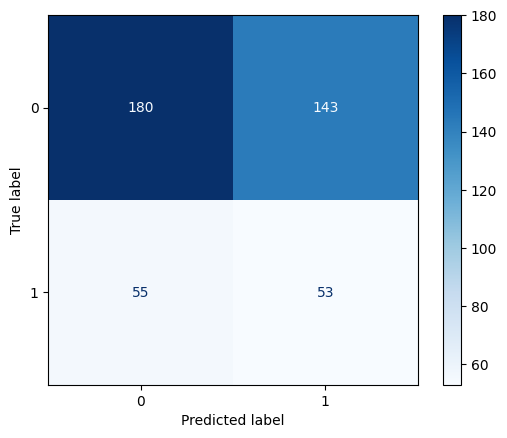

In [203]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = np.argmax(model.predict(X_val), axis=1)

cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.show()

### Exercise Classifier

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_seg, y_exercise, test_size=0.2, random_state=42, stratify=y_exercise
)

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1724, 50, 45), (1724,), (431, 50, 45), (431,))

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

num_features = X_train.shape[2]
scalers = []

for i in range(num_features):
    scaler = StandardScaler()
    # Flatten samples x timesteps into one long vector for this feature
    X_train[:, :, i] = scaler.fit_transform(X_train[:, :, i].reshape(-1, 1)).reshape(X_train.shape[0], X_train.shape[1])
    X_val[:, :, i] = scaler.transform(X_val[:, :, i].reshape(-1, 1)).reshape(X_val.shape[0], X_val.shape[1])
    scalers.append(scaler)


In [ ]:
from tensorflow.keras import layers, models

num_classes = len(np.unique(y_seg_majority))
window_size = X_train.shape[1]
num_features = X_train.shape[2]

model = models.Sequential([
    layers.Input(shape=(window_size, num_features)),
    layers.Bidirectional(layers.LSTM(128)),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       178,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 180,232 (704.03 KB)

 Trainable params: 180,232 (704.03 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model = model.fit(
    X_train,
    y_train,  # Convert one-hot to class indices
    epochs=10,
    validation_data=(X_val, y_val)
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9089 - loss: 0.3631 - val_accuracy: 1.0000 - val_loss: 0.0202
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9936 - loss: 0.0208 - val_accuracy: 1.0000 - val_loss: 0.0062
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 9.5829e-04
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 7.2378e-04
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 1.0000 - loss: 8.7018e-04 - val_accuracy: 1.0000 - val_loss: 5.6587e-04
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 1.0000 - loss: 6.7217e-04 - val_

## Data Export

Run everything in the ipynb and finish here

In [ ]:
import pickle

train_dict = {
    'X_seg': X_seg,
    'y_activity': y_activity,
    'y_exercise': y_exercise,
    'y_execution': y_execution,
}

test_dict = {
    'X_test': X_test,
    'y_test_exercise': y_test_exercise
}

with open('../data/training.pkl', 'wb') as f:
    pickle.dump(train_dict, f)
    
with open('../data/test.pkl', 'wb') as f:
    pickle.dump(test_dict, f)